In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn import tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, f1_score, roc_curve, auc, accuracy_score, confusion_matrix, classification_report, roc_auc_score

from yellowbrick.classifier import ROCAUC
from yellowbrick.datasets import load_game

import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 90)

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize 

//anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [ ]:
# 0 = dancehall
# 1 = reggae
# 2 = soca

In [2]:
df = pd.read_csv('data/working_clean.csv')

In [3]:
y = df['genre']
X = df.drop(columns=['genre','track_id'], axis=1)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=123)

# Baseline Stinky Model

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


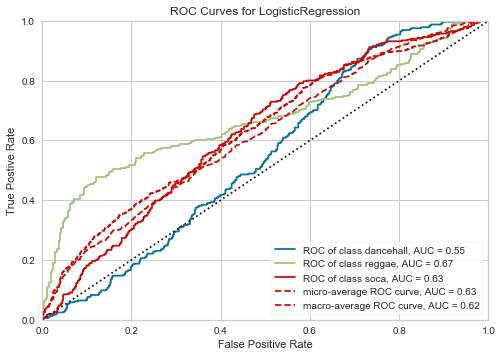

In [15]:
model = LogisticRegression()
visualizer = ROCAUC(model, classes=['dancehall','reggae','soca'])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show() 

# Pipeline

In [6]:
# Construct some pipelines
pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=5)),
                    ('log', OneVsRestClassifier(LogisticRegression(random_state=123)))])

pipe_dt = Pipeline([('scl', StandardScaler()),
                    ('tree', tree.DecisionTreeClassifier(random_state=123))])

pipe_bt = Pipeline([('scl', StandardScaler()),
                    ('bt', BaggingClassifier(tree.DecisionTreeClassifier(random_state = 123)))])

pipe_rf = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=5)),
                    ('rf', RandomForestClassifier(random_state=123))])

pipe_knn = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=5)),
                    ('knn', KNeighborsClassifier())])

# List of pipelines for ease of iteration
pipelines = [pipe_lr, pipe_dt, pipe_bt, pipe_rf, pipe_knn]

# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {0: 'Logistic Regression', 1: 'Decision Tree', 2: 'Bagged Decision Tree', 3: 'Random Forrest', 
             4: 'K Nearest'}

# Fit the pipelines
for pipe in pipelines:
    pipe.fit(X_train, y_train)
#     pipe.predict(X_test)

# # Compare accuracies
for idx, val in enumerate(pipelines):
#     print(val.f1_score())
     print('%s pipeline test accuracy: %.4f' % (pipe_dict[idx], val.score(X_test, y_test)))

# # Identify the most accurate model on test data
best_acc = 0.0
best_clf = 0
best_pipe = ''
for idx, val in enumerate(pipelines):
    if val.score(X_test, y_test) > best_acc:
        best_acc = val.score(X_test, y_test)
        best_pipe = val
        best_clf = idx
    
    
print('Classifier with best accuracy: %s' % pipe_dict[best_clf])

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Logistic Regression pipeline test accuracy: 0.8048
Decision Tree pipeline test accuracy: 0.7717
Bagged Decision Tree pipeline test accuracy: 0.8337
Random Forrest pipeline test accuracy: 0.7872
K Nearest pipeline test accuracy: 0.8017
Classifier with best accuracy: Bagged Decision Tree


# With GridSearch

In [7]:
# estimator = pipe_bt
# estimator.get_params().keys()

In [8]:
pipe_knn = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=5)),
                    ('knn', KNeighborsClassifier())])

param_grid_knn = {'knn__n_neighbors':[5,10,15,20] ,
                  'knn__leaf_size':[40,50,60,70],
                  'knn__algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']
                    }

gs_knn = GridSearchCV(pipe_knn, param_grid_knn, cv=5)

gs_knn.fit(X_train, y_train)

gs_knn_best = gs_knn.best_params_
print(gs_knn_best)

{'knn__algorithm': 'kd_tree', 'knn__leaf_size': 40, 'knn__n_neighbors': 10}


###### Decision tree cannot be optimised beyond basic model

In [9]:
pipe_dt = Pipeline([('scl', StandardScaler()),
                    ('tree', tree.DecisionTreeClassifier(random_state=123))])

param_grid_dt = {'tree__max_features':[6,8,10],
                 'tree__min_samples_leaf':[5,10,15],
                 'tree__max_depth':[3,4,5,6,7,8,9]  
             }

gs_dt = GridSearchCV(pipe_dt, param_grid_dt, cv=5)

gs_dt.fit(X_train, y_train)
gs_dt.predict(X_test)

gs_dt_best = gs_dt.best_params_

print(gs_dt_best)

{'tree__max_depth': 9, 'tree__max_features': 8, 'tree__min_samples_leaf': 15}


In [10]:
pipe_lr_1 = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=5)),
                    ('log', OneVsRestClassifier(LogisticRegression(random_state=123, solver='saga')))])

param_grid_lr = {'log__estimator__penalty':['elasticnet'],
                'log__estimator__max_iter':[100,200,300,400,500],
                 'log__estimator__l1_ratio':[0.2,0.4,0.6,0.8]
                 }

gs_lr_1 = GridSearchCV(pipe_lr_1, param_grid_lr, cv=5)

gs_lr_1.fit(X_train, y_train)

gs_lr_1_best = gs_lr_1.best_params_

print(gs_lr_1_best)

{'log__estimator__l1_ratio': 0.2, 'log__estimator__max_iter': 500, 'log__estimator__penalty': 'elasticnet'}


In [11]:
pipe_lr_2 = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=5)),
                    ('log', OneVsRestClassifier(LogisticRegression(random_state=123, multi_class='multinomial', class_weight='balanced')))])

param_grid_lr = {'log__estimator__penalty':['l2'],
                 'log__estimator__solver':['newton-cg','sag','lbfgs'],
                 'log__estimator__max_iter':[75,100,125,150]
                 }

gs_lr_2 = GridSearchCV(pipe_lr_2, param_grid_lr, cv=5)

gs_lr_2.fit(X_train, y_train)

gs_lr_2_best = gs_lr_2.best_params_

print(gs_lr_2_best)

{'log__estimator__max_iter': 75, 'log__estimator__penalty': 'l2', 'log__estimator__solver': 'lbfgs'}


In [12]:
pipe_bt = Pipeline([('scl', StandardScaler()),
                    ('bt', BaggingClassifier(tree.DecisionTreeClassifier(random_state = 123), random_state=123))])


param_grid_bt = {'bt__base_estimator__max_features':[6,8,10],
                 'bt__base_estimator__min_samples_leaf':[5,7,9],
                 'bt__base_estimator__max_depth':[10,11,12,13,14],
                 'bt__n_estimators':[10,12,14,16]
             }

gs_bt = GridSearchCV(pipe_bt, param_grid_bt, cv=5)

gs_bt.fit(X_train, y_train)
gs_bt.predict(X_test)

gs_bt_best = gs_bt.best_params_

print(gs_bt_best)

{'bt__base_estimator__max_depth': 13, 'bt__base_estimator__max_features': 10, 'bt__base_estimator__min_samples_leaf': 5, 'bt__n_estimators': 16}


In [13]:
pipes = [gs_lr_1, gs_lr_2, gs_dt, gs_bt, gs_knn]
pipe_dict = {0: 'Log Reg Elastic', 1: 'Log Reg Laso', 2: 'Decision Tree', 3: 'Bagged Tree', 4: 'K Nearest'}

def best_pipe(pipes, pipe_dict):
    for pipe in pipes:
        pip = pipe.best_estimator_
        pip.fit(X_train, y_train)

        # # Compare accuracies
    for idx, val in enumerate(pipes):
         print('%s pipeline test accuracy: %.4f' % (pipe_dict[idx], val.score(X_test, y_test)))

    # Identify the most accurate model on test data
    best_acc = 0.0
    best_clf = 0
    best_pipe = ''
    for idx, val in enumerate(pipes):
        if val.score(X_test, y_test) > best_acc:
            best_acc = val.score(X_test, y_test)
            best_pipe = val
            best_clf = idx

    # Save pipeline to file
    joblib.dump(best_pipe, 'best_pipeline.pkl', compress=1)
    print('Saved %s pipeline to file' % pipe_dict[best_clf])
  
best_pipe(pipes, pipe_dict)

Log Reg Elastic pipeline test accuracy: 0.8079
Log Reg Laso pipeline test accuracy: 0.7944
Decision Tree pipeline test accuracy: 0.7717
Bagged Tree pipeline test accuracy: 0.8554
K Nearest pipeline test accuracy: 0.8099
Saved Bagged Tree pipeline to file


# ROC of best model

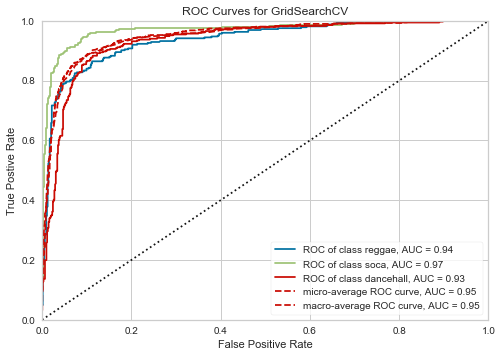

In [14]:
model = gs_bt
visualizer = ROCAUC(model, classes=['reggae','soca','dancehall'])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show() 